In [14]:
import enum
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor, State
from pgmpy.inference import BeliefPropagation
from pgmpy.models import FactorGraph, BayesianModel
from pgmpy.factors.continuous import ContinuousFactor
import numpy as np
from pgmpy.sampling import GibbsSampling, BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork



In [16]:


class Shape:
    """Abstract class for shapes to inherit from. """
    pass

class Circle(Shape):
    """A circle defined by position, circumference, and colour (colour can be anything matplotlib accepts for colour"""
    def __init__(self, position, circumference, colour):
        self.position = position
        self.circumference = circumference
        self.colour = colour
        self.type = 'circle'
    
    def draw(self):
        return plt.Circle(self.position, self.circumference, fc=self.colour)
    
    
    
class Rectangle(Shape):
     """A rectangle defined by position, height, width, and colour (colour can be anything matplotlib accepts for colour"""
    def __init__(self, position, height, width, colour):
        self.position = position
        self.height = height
        self.width = width
        self.colour = colour
        self.type = 'rectangle'
        
    def draw(self):
        return plt.Rectangle(self.position, self.height, self.width, fc=self.colour)
    
class Scene:
    """A scene containing a number of shapes (passed in init)"""
    def __init__(self, shapes):
        self.shapes = shapes
        
    def draw(self):
        plt.axes()
        for shape in self.shapes:
            s = shape.draw()
            plt.gca().add_patch(s)
        plt.axis('scaled')
        plt.show()


class Perspective(enum.Enum):
    """here we define the different perspectives which we use. Currently just two perspectives
    p1 represents looking at the scene from the "normal" direction while p2 represents looking at it "upside down" """
    p1 = 0
    p2 = 1

In [17]:
def left_of(o_1, o_2, perspective):
    """is o_1 left of o_2 given a particular perspective?"""
    x_1 = o_1.position[0]
    x_2 = o_2.position[0]
    
    if perspective == Perspective.p1:
        diff = x_1 - x_2
    else:
        diff = x_2 - x_1
    
    return diff < 0

def right_of(o_1, o_2, perspective):
    """is o_1 right of o_2 given a particular perspective?"""
    return not left_of(o_1, o_2, perspective)

def is_colour(o, colour):
    """check if object o has a particular colour. Here we assume the same method of defining colour is used (namely by name)"""
    return o.colour == colour

def is_colour_uncertain(o, colour):
    return 0.9 if o.colour == colour else 0.1

Having set up classes for shapes with colours and a scene we show an example scene and test the functions for checking left or right and the colour of objects

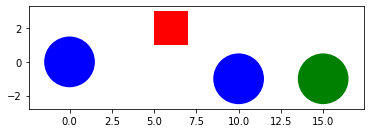

object 0 left of object 1 with perspective p1? True
object 0 left of object 1 with perspective p2? False
object 0 right of object 1 with perspective p1? False
object 0 right of object 1 with perspective p2? True
is object 0 blue? True
is object 0 red? False
is object 1 blue? False
is object 1 red? True


In [26]:
c = Circle((0, 0), 1.5, 'blue')
r = Rectangle((5, 1), 2, 2, 'red')
c2 = Circle((10, -1), 1.5, 'blue')
c3 = Circle((15, -1), 1.5, 'green')

s = Scene([c, r, c2, c3])
s.draw()

print('object 0 left of object 1 with perspective p1?', left_of(c, r, Perspective.p1))
print('object 0 left of object 1 with perspective p2?', left_of(c, r, Perspective.p2))
print('object 0 right of object 1 with perspective p1?', right_of(c, r, Perspective.p1))
print('object 0 right of object 1 with perspective p2?', right_of(c, r, Perspective.p2))

print('is object 0 blue?', is_colour(c, 'blue'))
print('is object 0 red?',is_colour(c, 'red'))
print('is object 1 blue?',is_colour(r, 'blue'))
print('is object 1 red?',is_colour(r, 'red'))

In the bayes net each node contains a Conditional Probability Distribution (CPD)
This is simply a table which gives a probability for a choice of parameters. 
When we're looking at colour, direction, perspective we are making a binary decision between e.g. an object being red or not being red for this reason we have two lists: one for the postive outcome, i.e. that the object is red, and one for the negative outcome. 
The expected format of this decision is:

[P(red(o_1))=0, P(red(o_2))=0, ...], 
[P(red(o_1))=1, P(red(o_2))=1, ...]


In [25]:
def make_colour_cpd(colour, objects):
    """Gives the probability that each object is the specified colour
    In this case the expected output is either 0 or 1 
    but we could replace the is_colour function to capture uncertainty
    
    """
    object_is_colour = [int(is_colour(o, colour)) for o in objects]
    # try using the fucntion below to see what would happen if we simply place a 90% chance of an object being a particular colour if it matches the name
    # object_is_colour = [int(is_colour_uncertain(o, colour)) for o in objects]
    object_is_not_colour = [1-p for p in object_is_colour]
    return [object_is_colour, object_is_not_colour]

def make_dir_cpd(direction, objects):
    """Creates a conditional probability table for left or right using the direction functions "left_of" and "right_of".
    provides 0 or 1 probability. If we want to use logan and sadler we'd include that here"""
    if direction == 'left':
        direction_function = left_of
    elif direction == 'right':
        direction_function = right_of
    else:
        raise ValueError(f"expected direction to be left or right not {direction}")
    
    t = []
    f = []
    for o1 in objects:
        for o2 in objects:
            for p in [Perspective.p1, Perspective.p2]:
                if o1 == o2:
                    result = False
                else:
                    result = direction_function(o1, o2, p)
                t.append(int(result))
                f.append(1-int(result))
    return [f, t]

def make_perspective_cpd():
    """This is the conditional "transition" probability for perspective. 
       The idea is simply that if the perspective stays the same then we have higher probability."""
    return [[0.7, 0.3], 
            [0.3, 0.7]]
            
    

            
            

objects = [c, r, c2, c3]

# Here we're building the probabilistic model using PGMpy
# each CPD has a name which represents a particular node in the network
# second we have the number of possible values of that node (2 for binary, for X and Y we use the number of objects)
# third we have the actual probability table
# evidence is the variables which influence the conditional probability
# evidence card is equivalent to the second parameter, i.e. how many possible values the variable has (but for the evidence variables)

red_cpd = TabularCPD('red(X)', 2, make_colour_cpd('red', objects), evidence=['X'], evidence_card=[len(objects)])
blue_cpd = TabularCPD('blue(Y)', 2, make_colour_cpd('blue', objects), evidence=['Y'], evidence_card=[len(objects)])

left_cpd = TabularCPD('left(X,Y)', 2, make_dir_cpd('left', objects), evidence=['X', 'Y', 'p'], evidence_card=[len(objects), len(objects), 2])

perspective_cpd = TabularCPD('p', 2, [[.7], [.3]])

X_cpd = TabularCPD('X', len(objects), [[1./len(objects)]]*len(objects))
Y_cpd = TabularCPD('Y', len(objects), [[1./len(objects)]]*len(objects))

# In the model we specify the edges between nodes with (X, red(X)) meaning P(red(X)|X) 
# and if we have several edges: (X, left(X,Y)) (Y, left(X, Y)) then that implies the conditioning set being larger: P(left(X, Y)|X, Y)
model = BayesianNetwork([('X', 'red(X)'), ('Y', 'blue(Y)'), ('X', 'left(X,Y)'), ('Y', 'left(X,Y)'), ('p', 'left(X,Y)')])

# Next we add the CPDs to the model. We need to make sure that all variables in the CPDs are covered in the edges
model.add_cpds(red_cpd, blue_cpd, left_cpd, perspective_cpd, X_cpd, Y_cpd)
model.check_model()

# We use variable elimination for inference. 
# There are a few different inference options in pgmpy, I just picked one that works for the type of model we have (BayesianNetwork)
infer = VariableElimination(model)

# In the query we specify the variables we want probabilities for and the evidence we have
# Evidence fixes the value of a variable, so although red(X) could be true or false we require it to be true here
# The variables that aren't mentioned in the query are "eliminated" in VariablieElimination
# This essentially just means that we sum over the possible values of that variable
# In this case that means we're summing over the different values of p
# What this means is that the probabilities we see take into account both of the perspectives when producing probabilities. 
q = infer.query(['X', 'Y'], evidence={'red(X)':1, 'blue(Y)':1, 'left(X,Y)':1})
print(q)

q = infer.query(['X'], evidence={'red(X)':1, 'blue(Y)':1, 'left(X,Y)':1})
print(q)

q = infer.query(['Y'], evidence={'red(X)':1, 'blue(Y)':1, 'left(X,Y)':1})
print(q)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------+------+------------+
| Y    | X    |   phi(Y,X) |
+======+======+============+
| Y(0) | X(0) |     0.0000 |
+------+------+------------+
| Y(0) | X(1) |     1.0000 |
+------+------+------------+
| Y(0) | X(2) |     0.0000 |
+------+------+------------+
| Y(0) | X(3) |     0.0000 |
+------+------+------------+
| Y(1) | X(0) |     0.0000 |
+------+------+------------+
| Y(1) | X(1) |     0.0000 |
+------+------+------------+
| Y(1) | X(2) |     0.0000 |
+------+------+------------+
| Y(1) | X(3) |     0.0000 |
+------+------+------------+
| Y(2) | X(0) |     0.0000 |
+------+------+------------+
| Y(2) | X(1) |     0.0000 |
+------+------+------------+
| Y(2) | X(2) |     0.0000 |
+------+------+------------+
| Y(2) | X(3) |     0.0000 |
+------+------+------------+
| Y(3) | X(0) |     0.0000 |
+------+------+------------+
| Y(3) | X(1) |     0.0000 |
+------+------+------------+
| Y(3) | X(2) |     0.0000 |
+------+------+------------+
| Y(3) | X(3) |     0.0000 |
+------+------

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| X    |   phi(X) |
+======+==========+
| X(0) |   0.0000 |
+------+----------+
| X(1) |   1.0000 |
+------+----------+
| X(2) |   0.0000 |
+------+----------+
| X(3) |   0.0000 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.3000 |
+------+----------+
| Y(1) |   0.0000 |
+------+----------+
| Y(2) |   0.7000 |
+------+----------+
| Y(3) |   0.0000 |
+------+----------+


In [138]:
green_cpd = TabularCPD('green(Z)', 2, make_colour_cpd('green', objects), evidence=['Z'], evidence_card=[len(objects)])

Z_cpd = TabularCPD('Z', len(objects), [[1./len(objects)]]*len(objects))

left1_cpd = TabularCPD('left(X,Y)', 2, make_dir_cpd('left', objects), evidence=['X', 'Y', 'p1'], evidence_card=[len(objects), len(objects), 2])
left2_cpd = TabularCPD('left(Y,Z)', 2, make_dir_cpd('left', objects), evidence=['Y', 'Z', 'p2'], evidence_card=[len(objects), len(objects), 2])

perspective1_cpd = TabularCPD('p1', 2, [[.5], [.5]])
perspective2_cpd = TabularCPD('p2', 2, make_perspective_cpd(), evidence=['p1'], evidence_card=[2])



model2 = BayesianNetwork([('X', 'red(X)'), ('Y', 'blue(Y)'), ('Z', 'green(Z)'), ('X', 'left(X,Y)'), ('Y', 'left(X,Y)'), ('Y', 'left(Y,Z)'), ('Z', 'left(Y,Z)'),  ('p1', 'left(X,Y)'), ('p1', 'p2'), ('p2', 'left(Y,Z)')])

model2.add_cpds(red_cpd, blue_cpd, green_cpd, left1_cpd, left2_cpd, X_cpd, Y_cpd, Z_cpd, perspective1_cpd, perspective2_cpd)

infer = VariableElimination(model2)
q = infer.query(['X', 'Y', 'Z'], evidence={'red(X)':1, 'blue(Y)':1, 'green(Z)':1, 'left(X,Y)':1, 'left(Y,Z)':1})
print(q)

q = infer.query(['X'],  evidence={'red(X)':1, 'blue(Y)':1, 'green(Z)':1, 'left(X,Y)':1, 'left(Y,Z)':1})
print(q)

q = infer.query(['Y'],  evidence={'red(X)':1, 'blue(Y)':1, 'green(Z)':1, 'left(X,Y)':1, 'left(Y,Z)':1})
print(q)

q = infer.query(['Z'],  evidence={'red(X)':1, 'blue(Y)':1, 'green(Z)':1, 'left(X,Y)':1, 'left(Y,Z)':1})
print(q)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+------+------+------+--------------+
| Z    | Y    | X    |   phi(Z,Y,X) |
+======+======+======+==============+
| Z(0) | Y(0) | X(0) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(0) | X(1) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(0) | X(2) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(0) | X(3) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(1) | X(0) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(1) | X(1) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(1) | X(2) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(1) | X(3) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(2) | X(0) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(2) | X(1) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(2) | X(2) |       0.0000 |
+------+------+------+--------------+
| Z(0) | Y(2) | X(3) |       0.0000 |
+------+----

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+------+----------+
| X    |   phi(X) |
+======+==========+
| X(0) |   0.0000 |
+------+----------+
| X(1) |   1.0000 |
+------+----------+
| X(2) |   0.0000 |
+------+----------+
| X(3) |   0.0000 |
+------+----------+


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.3000 |
+------+----------+
| Y(1) |   0.0000 |
+------+----------+
| Y(2) |   0.7000 |
+------+----------+
| Y(3) |   0.0000 |
+------+----------+


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+------+----------+
| Z    |   phi(Z) |
+======+==========+
| Z(0) |   0.0000 |
+------+----------+
| Z(1) |   0.0000 |
+------+----------+
| Z(2) |   0.0000 |
+------+----------+
| Z(3) |   1.0000 |
+------+----------+


In [76]:
print(red_cpd)

+-----------+------+------+------+------+
| X         | X(0) | X(1) | X(2) | X(3) |
+-----------+------+------+------+------+
| red(X)(0) | 1.0  | 0.0  | 1.0  | 1.0  |
+-----------+------+------+------+------+
| red(X)(1) | 0.0  | 1.0  | 0.0  | 0.0  |
+-----------+------+------+------+------+


In [77]:
print(left_cpd)

+---------------+------+------+------+-----+------+------+------+------+------+
| X             | X(0) | X(0) | X(0) | ... | X(3) | X(3) | X(3) | X(3) | X(3) |
+---------------+------+------+------+-----+------+------+------+------+------+
| Y             | Y(0) | Y(0) | Y(1) | ... | Y(1) | Y(2) | Y(2) | Y(3) | Y(3) |
+---------------+------+------+------+-----+------+------+------+------+------+
| p             | p(0) | p(1) | p(0) | ... | p(1) | p(0) | p(1) | p(0) | p(1) |
+---------------+------+------+------+-----+------+------+------+------+------+
| left(X, Y)(0) | 1.0  | 1.0  | 0.0  | ... | 0.0  | 1.0  | 0.0  | 1.0  | 1.0  |
+---------------+------+------+------+-----+------+------+------+------+------+
| left(X, Y)(1) | 0.0  | 0.0  | 1.0  | ... | 1.0  | 0.0  | 1.0  | 0.0  | 0.0  |
+---------------+------+------+------+-----+------+------+------+------+------+
